<a href="https://colab.research.google.com/github/dclark18/hbo_spike_analysis/blob/main/HBO_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
url = 'https://raw.githubusercontent.com/dclark18/hbo_spike_analysis/main/conversion_date_hour.csv'

In [14]:
df = pd.read_csv(url,index_col=0,parse_dates=[0])
df['Conversions'] = df['Conversions'].fillna(0)
df.head()

,Impressions,Conversions
DATE_HOUR,,
2021-09-15-00,5175,50.0
2021-09-15-01,4858,51.0
2021-09-15-02,4134,50.0
2021-09-15-03,3776,50.0
2021-09-15-04,5399,56.0


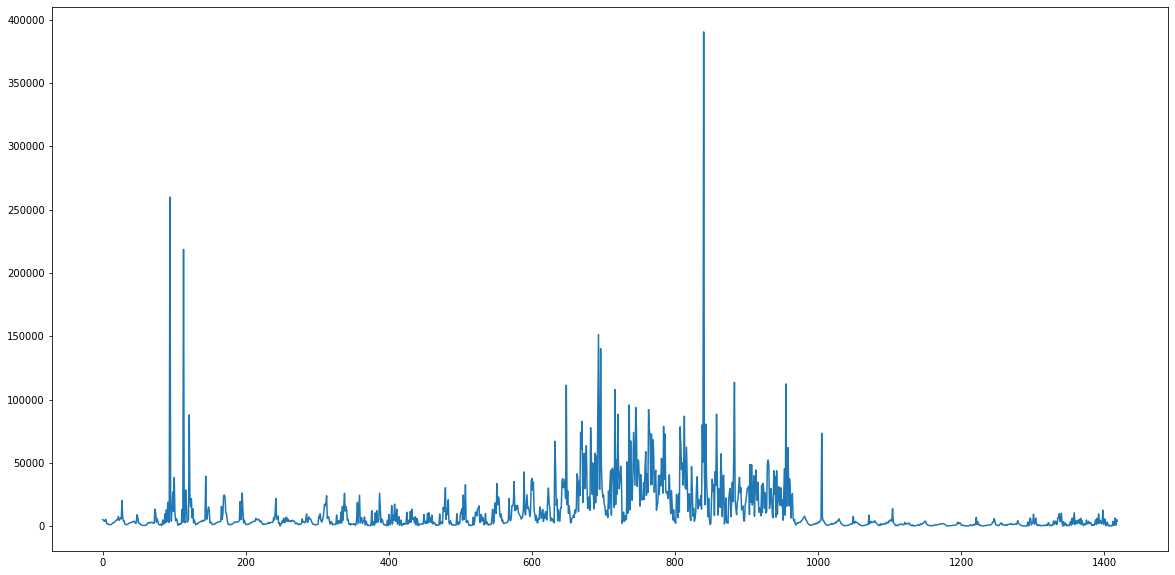

<Figure size 1440x720 with 0 Axes>

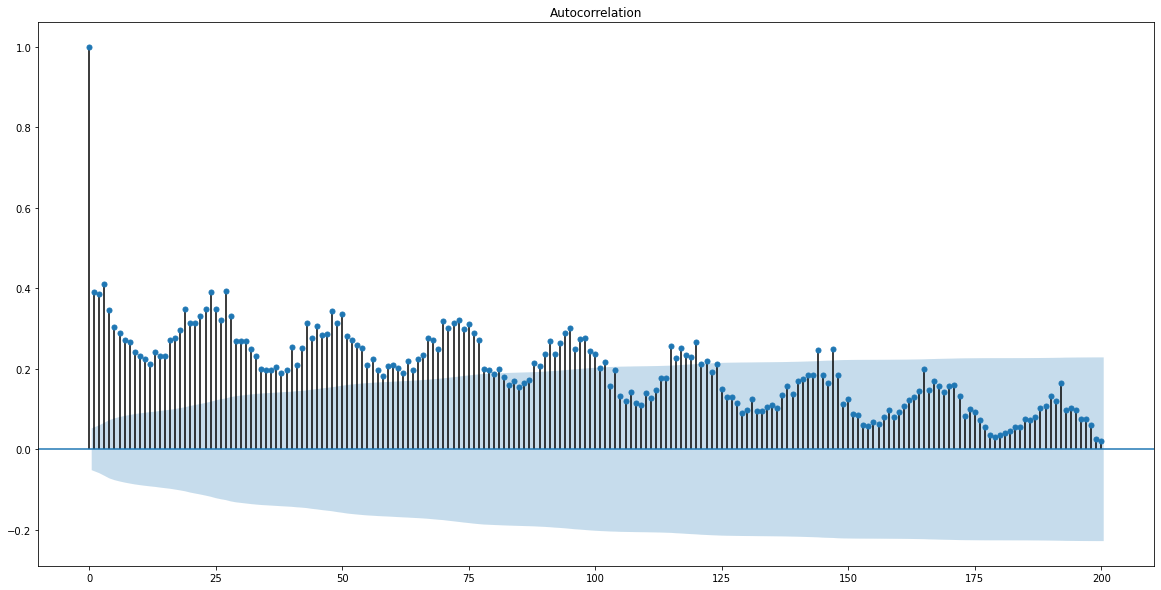

In [15]:
data_a = df.to_numpy().T[0]
data_a
plt.figure(figsize=(20,10))
plt.plot(data_a)

plt.rc("figure", figsize=(20,10))
plt.figure(figsize=(20,10))
plot_acf(data_a, lags=200)
plt.show()



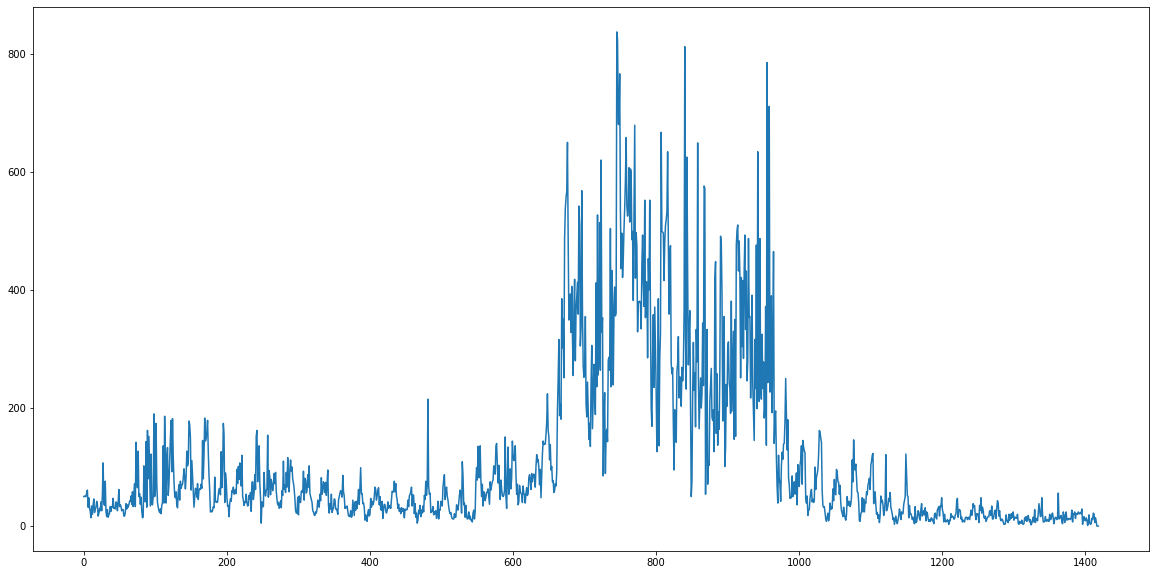

<Figure size 1440x720 with 0 Axes>

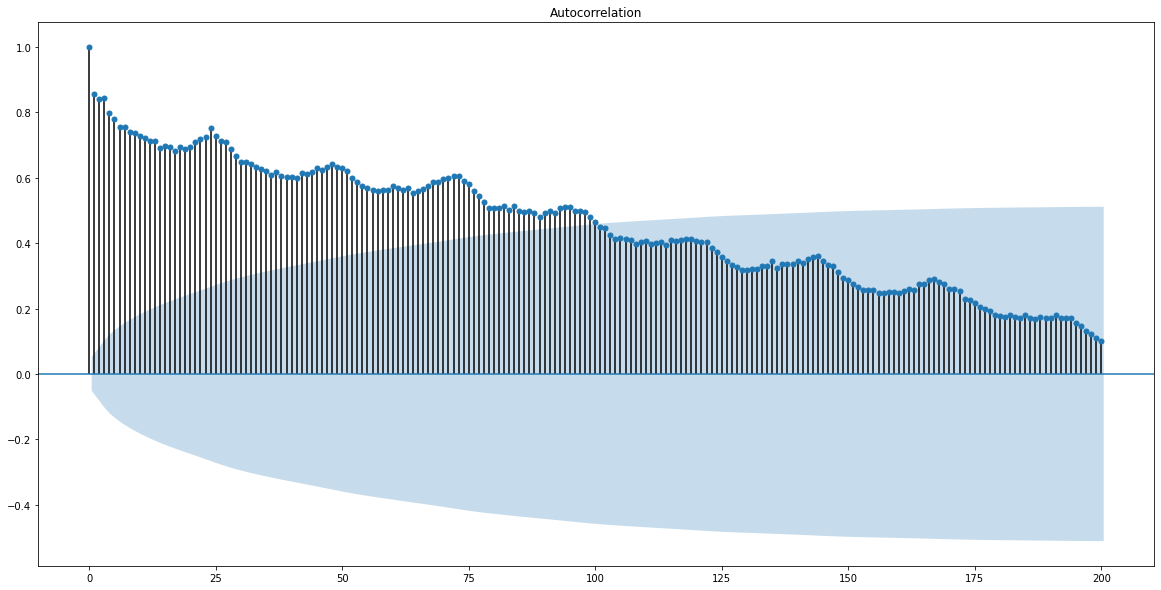

In [16]:
data_b = df.to_numpy().T[1]
data_b
plt.figure(figsize=(20,10))
plt.plot(data_b)

plt.rc("figure", figsize=(20,10))
plt.figure(figsize=(20,10))
plot_acf(data_b, lags=200)
plt.show()

In [17]:
data_b

array([50., 51., 50., ...,  0.,  0.,  0.])

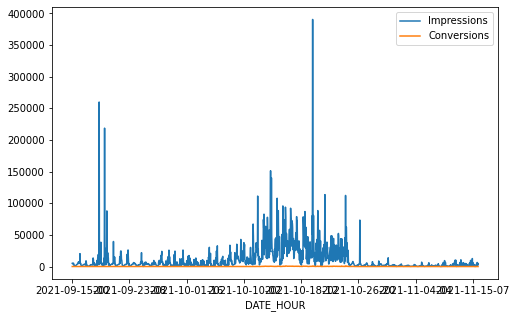

In [18]:
df.plot(figsize = (8,5))

## Testing Stationarity
Perform the Dickey Fuller test to find stationarity of the series using AIC criteria. 

In [19]:
from statsmodels.tsa.stattools import adfuller
adfuller_test = adfuller(df['Impressions'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -2.132806927202258
p-value: 0.2315289766941091


In [20]:
from statsmodels.tsa.stattools import adfuller
adfuller_test = adfuller(df['Conversions'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -1.4935735736341818
p-value: 0.5366879708939717


P-Value is not significant so we fail to reject the null hypothesis that the series is stationary for both impressions and conversions. 

## Differencing
Now let's difference the data since it's not stationary

In [21]:
data_diff = df.diff().dropna()

In [22]:
adfuller_test = adfuller(data_diff['Impressions'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -16.10671956716361
p-value: 5.0635916290828e-29


After Differencing, the Impressions is now stationary. 

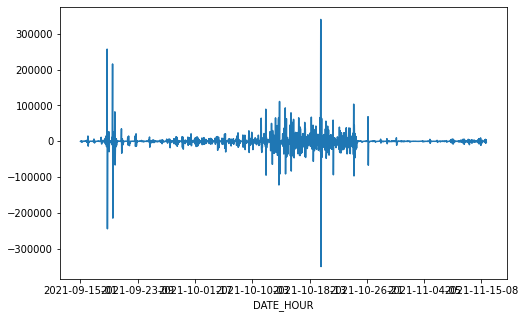

In [23]:
data_diff['Impressions'].plot(figsize = (8,5))

## Modeling
In this section, we apply the VAR model on the one differenced series. We carry-out the train-test split of the data and keep the last 10-days as test data.


In [24]:
train = data_diff.iloc[:-100,:]
test = data_diff.iloc[-100:,:]

In [33]:
forecasting_model = VAR(train)
results_aic = []
for p in range(1,50):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


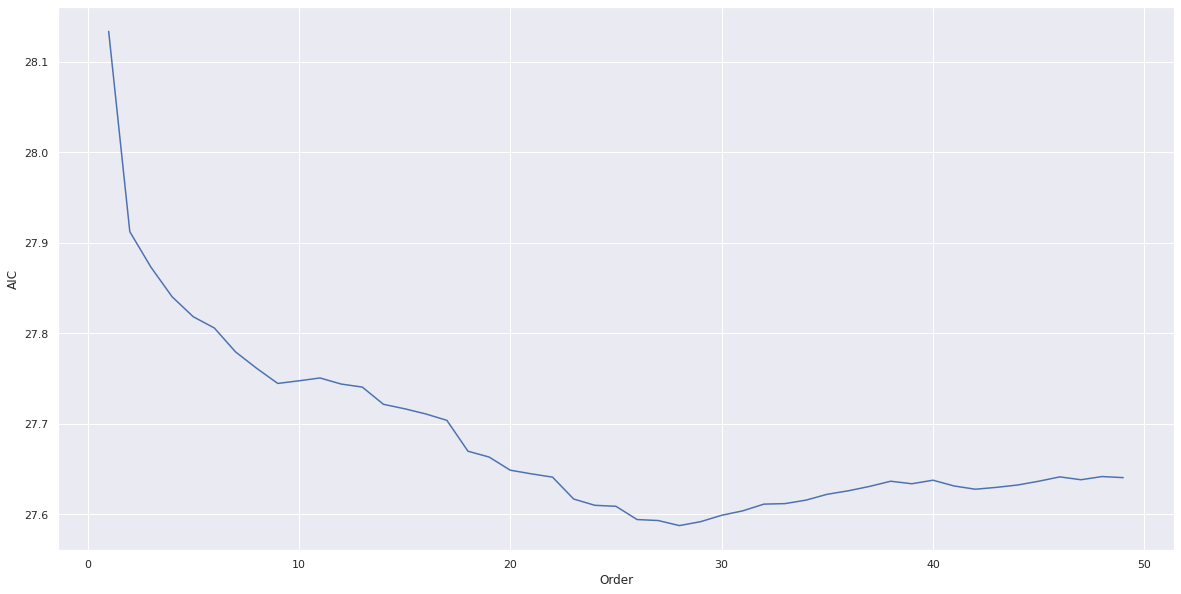

In [34]:
import seaborn as sns
sns.set()
plt.plot(list(np.arange(1,50,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

From the plot, the lowest AIC score is achieved at the order of 28 and then the AIC scores show an increasing trend with the order p gets larger. Hence, we select the 28 as the optimal order of the VAR model. Consequently, we fit order 28 to the forecasting model.

In [35]:
results = forecasting_model.fit(28)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 09, Dec, 2021
Time:                     21:35:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    28.0437
Nobs:                     1290.00    HQIC:                   27.7587
Log likelihood:          -21340.8    FPE:                9.57490e+11
AIC:                      27.5875    Det(Omega_mle):     8.78169e+11
--------------------------------------------------------------------
Results for equation Impressions
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                 -25.372724       502.088523           -0.051           0.960
L1.Impressions         -0.939105         0.033578          -27.968           0.000
L1.Conversions         14.968694         9.829

## Forecasting

In [36]:
train.values[-28:]

array([[ 5.500e+01, -1.000e+00],
       [ 3.600e+01, -2.000e+00],
       [ 3.075e+03,  1.400e+01],
       [-3.084e+03, -1.000e+01],
       [ 6.480e+02,  1.000e+01],
       [ 5.441e+03, -7.000e+00],
       [-4.910e+02,  8.000e+00],
       [-4.853e+03, -6.000e+00],
       [ 1.262e+03,  9.000e+00],
       [ 4.070e+02, -1.400e+01],
       [ 6.711e+03,  5.000e+00],
       [-7.815e+03,  0.000e+00],
       [ 5.220e+02, -2.000e+00],
       [ 4.276e+03,  1.000e+00],
       [-4.052e+03,  6.000e+00],
       [-1.656e+03, -1.500e+01],
       [ 6.070e+02, -2.000e+00],
       [-8.730e+02,  5.000e+00],
       [ 3.970e+02, -3.000e+00],
       [ 1.960e+02,  0.000e+00],
       [-7.530e+02,  5.000e+00],
       [ 9.500e+01, -6.000e+00],
       [ 1.370e+02, -1.000e+00],
       [-1.040e+02,  1.000e+00],
       [ 4.200e+02,  1.000e+01],
       [-1.270e+02, -4.000e+00],
       [-1.520e+02,  6.000e+00],
       [ 2.290e+02, -8.000e+00]])

In [39]:
lagged_values = train.values[-28:]
forecast = pd.DataFrame(results.forecast(y= lagged_values, steps=100), index = test.index, columns= ['Impressions_1d', 'Conversions_1d'])
forecast

,Impressions_1d,Conversions_1d
DATE_HOUR,,
2021-11-11-08,1815.844183,4.109617
2021-11-11-09,1348.746220,1.387536
2021-11-11-10,-1299.732656,1.622355
2021-11-11-11,-638.613244,-1.386416
2021-11-11-12,2843.276381,4.909954
...,...,...
2021-11-15-21,44.007015,0.135621
2021-11-15-22,14.826065,0.044009
2021-11-15-23,37.572585,0.033829


In [42]:
forecast["Impressions_forecasted"] = df["Impressions"].iloc[-100-1] +   forecast['Impressions_1d'].cumsum()
forecast["Conversions_forecasted"] = df["Conversions"].iloc[-100-1] +   forecast['Conversions_1d'].cumsum() 